# Development Notebook for Cortical Crowding Project

In [1]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import neuropythy as ny
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize
from scipy.stats import gmean
from scipy.optimize import curve_fit

In [2]:
# We want to be able to load in libraries that are in this repository's src directory,
# so we add src to the system path:
sys.path.append('../src')

# Now we can import corticalcrowding from the src directory:
import corticalcrowding as cc

In [3]:
df = pd.read_csv('/data/crowding/crowding_data_withID.csv')

In [4]:
sids_NYU = [
    'sub-wlsubj070',
    'sub-wlsubj114',
    'sub-wlsubj121',
    'sub-wlsubj135']
sids_NEI = [ 
    'sub-wlsubj119',
    'sub-wlsubj127',
    'sub-wlsubj136',
    'sub-wlsubj137',
    'sub-wlsubj143',
    'sub-wlsubj144',
    'sub-wlsubj145',
    'sub-wlsubj146',
    'sub-wlsubj147',
    'sub-wlsubj148',
    'sub-wlsubj149',
    'sub-wlsubj150',
    'sub-wlsubj151',
    'sub-wlsubj152',
    'sub-wlsubj153',
    'sub-wlsubj154',
    'sub-wlsubj155',
    'sub-wlsubj156',
    'sub-wlsubj157',
    'sub-wlsubj158',
    'sub-wlsubj159',
    'sub-wlsubj160',
    'sub-wlsubj161',
    'sub-wlsubj162',
    'sub-wlsubj163',
    'sub-wlsubj164',
    'sub-wlsubj165',
    'sub-wlsubj166',
    'sub-wlsubj167',
    'sub-wlsubj168',
    'sub-wlsubj170',
    'sub-wlsubj171',
    'sub-wlsubj172',
    'sub-wlsubj173',
    'sub-wlsubj174',
    'sub-wlsubj175',
    'sub-wlsubj176']

In [5]:
sids_orig = sids_NYU + sids_NEI

## crowding

In [6]:
# merge the 2 sessions, so now each sub have 12 cd (match with polar angle) instead of 24
mean_cd_polar = df.groupby(['ID','Eccen_X','Eccen_Y'])['CrowdingDistance'].apply(gmean).reset_index()

In [7]:
# each subject has 1 cd value at each eccentricity
mean_cd = df.groupby(['ID','RadialEccentricity'])['CrowdingDistance'].apply(gmean).reset_index()

In [8]:
cd_list = df['CrowdingDistance'].tolist()
mean_cd_list=mean_cd['CrowdingDistance'].tolist()

In [25]:
# create 3 dfs based on eccen
mean_1 = mean_cd[mean_cd['RadialEccentricity']==2.5]
n_1 = len(mean_1)
m_1 = mean_1['CrowdingDistance'].mean()
st_1 = mean_1['CrowdingDistance'].std()
mean_2 = mean_cd[mean_cd['RadialEccentricity']==5]
n_2 = len(mean_2)
m_2 = mean_2['CrowdingDistance'].mean()
st_2 = mean_2['CrowdingDistance'].std()
mean_3 = mean_cd[mean_cd['RadialEccentricity']==10]
n_3 = len(mean_3)
m_3 = mean_3['CrowdingDistance'].mean()
st_3 = mean_3['CrowdingDistance'].std()

In [26]:
x_ecc = df['RadialEccentricity'].tolist()
mean_x_ecc = mean_cd['RadialEccentricity'].tolist()

In [43]:
?curve_fit

In [36]:
def func_cd(x, b):
    # Wrap
    return np.log10(cc.crowding.Kurzawski2023_cd(x, b=b))

b, _ = curve_fit(cc.crowding.func_cd, x_ecc, np.log10(cd_list), p0=0.15)
b

array([0.19811346])

In [28]:
mean_values = [m_1, m_2, m_3]
std_values = [st_1, st_2, st_3]
sem_values = np.array([st_1, st_2, st_3]) / np.sqrt([n_1, n_2, n_3])
eccentricities = [2.5, 5, 10]

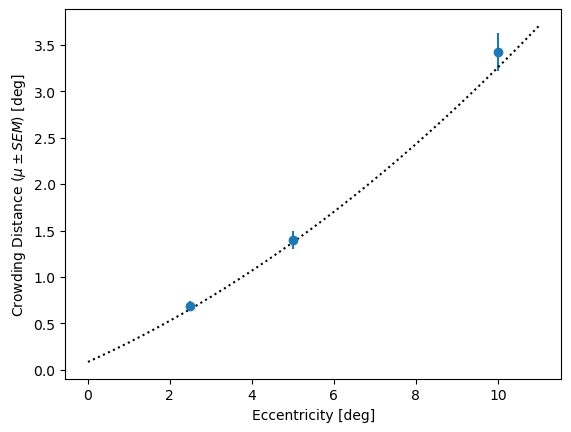

In [44]:
plt.errorbar(eccentricities, mean_values, sem_values, fmt='o')
plt.gca().set_xlabel('Eccentricity [deg]')
plt.gca().set_ylabel(r'Crowding Distance $(\mu \pm SEM)$ [deg]')
x = np.linspace(0,11,500)
y = 10**cc.crowding.func_cd(x, b)
plt.gca().plot(x, y, 'k:')
plt.show()

## fit cortical magnification

In [45]:
eccen = np.linspace(1, 11, 1000)

In [46]:
def cmag_basics(sid, h, label):
    sub = cc.cmag.load_subject(sid)
    hem = sub.hemis[h]
    mask_nor2 = {
        'and': [
            ('eccentricity', 0, 12),
            ('visual_area', label)]}
    mask_r2 = {'and': mask_nor2['and'] + [('variance_explained', 0.04, 1)]}
    rdat = ny.retinotopy_data(hem)
    mask_ii = hem.mask(mask_r2)
    ecc = rdat['eccentricity'][mask_ii]
    srf = hem.prop('midgray_surface_area')
    totarea = np.sum(srf[hem.mask(mask_nor2)])
    srf = srf[mask_ii]
    ii = np.argsort(ecc)
    ecc = ecc[ii]
    srf = srf[ii] * totarea / np.sum(srf)
    return (ecc, srf)

$$ c_1 = \sqrt{\frac{a_M}{\pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right)}} $$

In [47]:
def HH91_integral(x, a=17.3, b=0.75):
    xb = x + b
    return a**2 * np.pi * (np.log(xb / b) - x / xb)

def HH91_c1(totalarea, maxecc, b=0.75):
    mb = maxecc + b
    c1 = np.sqrt(totalarea / np.pi / (np.log(mb / b) - maxecc/mb))

def fit_cumarea_data(ecc, srf, params0=(17.3, 0.75), method=None):
    from scipy.optimize import minimize
    ecc = np.asarray(ecc, dtype=np.float64)
    srf = np.asarray(srf, dtype=np.float64)
    ii = np.argsort(ecc)
    ecc = ecc[ii]
    srf = srf[ii]
    cumsrf = np.cumsum(srf)
    def loss_vmag(params):
        params = list(params)
        params[1] = params[1]**2
        pred = HH91_integral(ecc, *params)
        error = (pred - cumsrf)
        return np.mean(error**2)
    params0 = list(params0)
    params0[1] = np.sqrt(params0[1])
    r = minimize(loss_vmag, params0, method=method)
    r.x[0] = abs(r.x[0])
    r.x[1] = r.x[1]**2
    r.coords = np.array([ecc,srf])
    return r

def fit_cumarea(sid, h, label):
    (ecc,srf) = cmag_basics(sid, h, label)
    if len(ecc) == 0:
        raise RuntimeError(f"no data found for {sid}:{h}:{label}")
    r = fit_cumarea_data(ecc, srf)
    r.coords = np.array([ecc, srf])
    return r

In [58]:
df = dict(sid=[], h=[], label=[], a=[], b=[], loss=[])
for sid in sids_orig:
    print(sid)
    for h in ['lh','rh']:
        for lbl in [1,2,3,4]:
            try:
                r = fit_cumarea(sid, h, lbl)
            except Exception as e:
                print(f"  - Skipping: {type(e)}")
                continue
            df['sid'].append(sid)
            df['h'].append(h)
            df['label'].append(lbl)
            df['a'].append(r.x[0])
            df['b'].append(r.x[1])
            df['loss'].append(r.fun)
HH91_params = pd.DataFrame(df)

sub-wlsubj070
sub-wlsubj114
sub-wlsubj121
sub-wlsubj135
sub-wlsubj119
sub-wlsubj127
sub-wlsubj136
sub-wlsubj137
sub-wlsubj143
sub-wlsubj144
sub-wlsubj145
sub-wlsubj146
sub-wlsubj147
sub-wlsubj148
sub-wlsubj149
sub-wlsubj150
sub-wlsubj151
sub-wlsubj152
sub-wlsubj153
sub-wlsubj154
sub-wlsubj155
sub-wlsubj156
sub-wlsubj157
sub-wlsubj158
sub-wlsubj159
sub-wlsubj160
sub-wlsubj161
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
sub-wlsubj162
sub-wlsubj163
sub-wlsubj164
sub-wlsubj165
sub-wlsubj166
sub-wlsubj167
sub-wlsubj168
sub-wlsubj170
sub-wlsubj171
sub-wlsubj172
sub-wlsubj173
sub-wlsubj174
sub-wlsubj175
sub-wlsubj176


### histogram of "a" parameter

In [ ]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['a'].values
        ax.hist(q)
        ax.set_xlim([0,30])

### histogram of "b" parameter

In [ ]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['b'].values
        ax.hist(q)
        #ax.set_xlim([0,2])

### plot hh91 fit vs eccentricity

In [ ]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.1,0.1)
eccrng = np.linspace(0.5, 11, 500)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        for (a,b) in zip(df2['a'].values, df2['b'].values):
            ax.loglog(eccrng, (a / (b + eccrng))**2, 'k-', alpha=0.1)

In [ ]:
df = HH91_params
(fig,axs) = plt.subplots(1,2, figsize=(4,1.5), dpi=288, sharex=True, sharey=True)
eccrng = np.linspace(0.5, 12, 500)
for (lbl,clr) in zip([1,2,3,4], ['r','g','b','k']):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axs):
        df2 = df1[df1['h'] == h]
        a = df2['a'].values
        b = df2['b'].values
        m = (a[:,None] / (b[:,None] + eccrng[None,:]))**2
        mu = np.mean(m, axis=0)
        sd = np.std(m, axis=0)
        ax.fill_between(eccrng, mu - sd, mu + sd, edgecolor=None, facecolor=clr, alpha=0.2, zorder=-1)
        ax.loglog(eccrng, mu, clr+'-', lw=1)

## have two dfs of fitted cortical magnification and crowding values based on VM/HM

In [ ]:
# merge the 2 sessions, so now each sub have 12 cd (match with polar angle) instead of 24
# mean_cd_polar = df.groupby(['ID','Eccen_X','Eccen_Y'])['CrowdingDistance'].apply(gmean).reset_index()
mean_cd_polar

In [ ]:
# only look at horizontal meridian for tmp_hor
# h is assigned 'lh' for x values larger than 0 and 'rh' otherwise
tmp_hor = mean_cd_polar[mean_cd_polar['Eccen_Y']==0]
x = tmp_hor['Eccen_X'].values
# for calculating cmag, have a col for abs(x)
tmp_hor['eccen'] = np.abs(x)
tmp_hor['h'] = np.where(x > 0, 'lh', 'rh')
tmp_hor.rename(columns={'CrowdingDistance': 'CrowdingDistance_HM'}, inplace=True)
tmp_hor.rename(columns={'ID': 'sid'}, inplace=True)

In [ ]:
# only look at vertical meridian for tmp_ver
tmp_ver = mean_cd_polar[mean_cd_polar['Eccen_X']==0]
y = tmp_ver['Eccen_Y'].values
tmp_ver['eccen'] = np.abs(y)

# Create the 'CrowdingDistance_UVM' and 'CrowdingDistance_LVM' columns
tmp_ver['CrowdingDistance_UVM'] = np.where(y > 0, np.nan, tmp_ver['CrowdingDistance'])
tmp_ver['CrowdingDistance_LVM'] = np.where(y > 0, tmp_ver['CrowdingDistance'], np.nan)
tmp_ver.rename(columns={'ID': 'sid'}, inplace=True)

In [ ]:
# Create duplicate rows with 'h' column
tmp_ver_lh = tmp_ver.copy()
tmp_ver_lh['h'] = 'lh'
tmp_ver_rh = tmp_ver.copy()
tmp_ver_rh['h'] = 'rh'

# Combine the two DataFrames, so now tmp_ver has two rows with same data except one row lh and one row rh
tmp_ver = pd.concat([tmp_ver_lh, tmp_ver_rh], ignore_index=True)
tmp_ver = tmp_ver.drop(columns=['CrowdingDistance'])

In [ ]:
df = HH91_params.copy()

# will have three rows for diff ecc, but the same a,b params
df = df.merge(
    pd.DataFrame(dict(eccen=[2.5, 5.0, 10.0])),
    how='cross')

a = df['a']
b = df['b']
ecc = df['eccen']
# calculate cmag based on a,b params from HH91_params
df['cmag_fit'] = (a / (ecc + b))**2
# add 1d visual magnification
df['1d_vmag_fit'] = np.sqrt(1/ (a / (ecc + b))**2)

In [ ]:
# add CrowdingDistance_HM to df by merging it with tmp_hor
# _full versions have x, y positions too
df_HM_full = df.merge(tmp_hor, on=['sid', 'eccen','h'])

In [ ]:
df_HM = df_HM_full.drop(columns=['Eccen_X', 'Eccen_Y']) # 15 subs, 2 hemisphere * 3 ecc * 4 visual area = 360 rows

In [ ]:
df_VM_full = df.merge(tmp_ver, on=['sid', 'eccen','h'])

In [ ]:
df_VM = df_VM_full.drop(columns=['Eccen_X', 'Eccen_Y']) #15 subs, 2 loc * 3 ecc * 4 visual area * 2h = 48

In [ ]:
df_VM = df_VM.groupby(
    ['sid', 'label', 'eccen'], as_index=False
).agg({
    'a': 'mean',
    'b': 'mean',
    'loss': 'mean',
    'CrowdingDistance_UVM': np.nanmean, 
    'CrowdingDistance_LVM': np.nanmean, 
})

# compute cmag_fit based on a, b, and eccen
df_VM['cmag_fit'] = (df_VM['a'] / (df_VM['eccen'] + df_VM['b']))**2

# compute 1d_vmag_fit from cmag_fit
df_VM['1d_vmag_fit'] = np.sqrt(1 / df_VM['cmag_fit'])


In [ ]:
df_VM

# for each subject, each visual area, to have a fitted cortical crowding distance

In [ ]:
def crowding_loss_notused(params, cd, cmags, position):
    '''
    position: 1 for horizontal, 2 for upper, 3 for lower
    params: d for cortical crowding distance, g_h, g_u, g_l
    cd: crowding distance
    cmags: cortical magnification
    '''
    gain = params[position] ** 2  # ensure that gain >= 0
    d = params[0]
    pred = d * np.sqrt(2/(gain*cmags))
    
    return np.sum((cd - pred)**2)

In [ ]:
# preferred for now
def crowding_loss(params, cd, cmags, position):
    '''
    position: 1 for horizontal, 2 for upper, 3 for lower
    params: d, g_h, g_u, g_l
    cd: crowding distance
    cmags: cortical magnification
    '''
    gain = np.exp(params[position])
    d = params[0]
    pred = d * np.sqrt(2/(gain*cmags))
    
    return np.sum((cd - pred)**2)

In [ ]:
def crowding_fit_data(df_HM, df_VM, sid, label):
    sub_hm = df_HM[(df_HM['label']==label) & (df_HM['sid']==sid)]
    cd_hm = sub_hm['CrowdingDistance_HM'].values
    cm_hm = sub_hm['cmag_fit'].values
    pos_hm = np.ones(len(cd_hm),dtype=int)
    
    sub_vm = df_VM[(df_VM['label']==label) & (df_VM['sid']==sid)]
    cd_um = sub_vm['CrowdingDistance_UVM'].values
    cd_lm = sub_vm['CrowdingDistance_LVM'].values
    cm_um = sub_vm['cmag_fit'].values
    cm_lm = sub_vm['cmag_fit'].values
    pos_um = np.ones(len(cd_um),dtype=int)*2
    pos_lm = np.ones(len(cd_lm),dtype=int)*3
    
    return(np.concatenate([cd_hm,cd_um,cd_lm]), np.concatenate([cm_hm,cm_um,cm_lm]), np.concatenate([pos_hm,pos_um,pos_lm]))

In [ ]:
crowding_fit_data(df_HM, df_VM, 'sub-wlsubj158', 1) # 12 vals, 6+3+3, hm: lh*3, rh*3, vm: mean for 3 ecc

In [ ]:
def crowding_fit_notused(df_HM, df_VM, sid, label, method = 'BFGS'):
    from scipy.optimize import minimize
    cd_cm = crowding_fit_data(df_HM, df_VM, sid, label)
    params0 = [1.5, np.sqrt(1), np.sqrt(1), np.sqrt(1)] 
    r = minimize(crowding_loss, params0, args=cd_cm, method=method)
    r.x[1] = r.x[1]**2
    r.x[2] = r.x[2]**2
    r.x[3] = r.x[3]**2
    return r

In [ ]:
def crowding_fit(df_HM, df_VM, sid, label, method = 'BFGS'):
    from scipy.optimize import minimize
    cd_cm = crowding_fit_data(df_HM, df_VM, sid, label)
    params0 = [1.5, np.log(1), np.log(1), np.log(1)] 
    r = minimize(crowding_loss, params0, args=cd_cm, method=method)
    r.x[1] = np.exp(r.x[1])
    r.x[2] = np.exp(r.x[2])
    r.x[3] = np.exp(r.x[3])
    return r

In [ ]:
df_fit = dict(sid=[], label=[], d=[], g_h=[], g_u=[], g_l=[], loss=[])
sids = np.unique(df_HM['sid'])
for sid in sids:
    for lbl in [1,2,3,4]:
        r = crowding_fit(df_HM, df_VM, sid, lbl)
        df_fit['sid'].append(sid)
        df_fit['label'].append(lbl)
        df_fit['d'].append(r.x[0])
        df_fit['g_h'].append(r.x[1])
        df_fit['g_u'].append(r.x[2])
        df_fit['g_l'].append(r.x[3])
        df_fit['loss'].append(r.fun)
    

In [ ]:
#df_fit_square = pd.DataFrame(df_fit)

In [ ]:
df_fit_exp = pd.DataFrame(df_fit)
df_fit_exp

In [ ]:
df_fit_exp.groupby('label')['loss'].mean()

In [ ]:
df_fit_exp.groupby('label')['d'].median()

In [ ]:
HH91_params.groupby('label')['loss'].mean()

In [ ]:
import seaborn as sns

In [ ]:
# exp
sns.violinplot(data=df_fit_exp,x='label',y='d',bw=0.15)

In [ ]:
sns.violinplot(data=df_fit_exp,x='label',y='loss',bw=0.15)

In [ ]:
# plots based on HM measurements
fig, axs = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.1,0.3)

for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df_HM[df_HM['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        loss = df2['loss']
        vmag = df2['1d_vmag_fit']
        cd = df2['CrowdingDistance_HM']
        eccen = df2['eccen']
        for (e,color) in zip([2.5,5,10],'rgb'):
            ii = (eccen==e)
            ax.scatter(vmag[ii], cd[ii], s=4*(2-loss[ii]/2000), c=color)
            ax.plot([0,2],[0,2],'k-')
            ax.set_title(f'{h} Label={lbl}', fontsize=6)
            
fig.text(0.5, -0.1, '1D Vmag Fit', ha='center', fontsize=8)
fig.text(-0.1, 0.5, 'Crowding Distance', va='center', rotation='vertical', fontsize=8)
plt.show()

In [ ]:
df_HM

## linear regression: predict crowding distance based on vmag_fit

In [ ]:
res = {1:[],2:[],3:[],4:[]}
for subject, subject_data in df_HM.groupby(['sid']):
    if (subject_data['b']>5).any():
        continue
    for h in ['lh','rh']:
        ssdf = subject_data[subject_data['h'] == h]
        for lbl in [1,2,3,4]:
            sssdf = ssdf[ssdf['label'] == lbl]
            x = sssdf['1d_vmag_fit'].values
            y = sssdf['CrowdingDistance_HM'].values
            (rss,coef) = cc.regression.fit_and_evaluate(x, y)
            res[lbl].append(rss)
            
print({k:np.mean(v) for (k,v) in res.items()})

In [ ]:
grouped = df_HM.groupby('sid') 
subject_results = {}

for subject, subject_data in grouped:
    if (subject_data['b']>5).any():
        continue
    subject_results[subject] = {}
    for h in ['lh', 'rh']:
        hemisphere_data = subject_data[subject_data['h'] == h]
        
        y1 = hemisphere_data[hemisphere_data['label'] == 1]['1d_vmag_fit'].values
        y2 = hemisphere_data[hemisphere_data['label'] == 2]['1d_vmag_fit'].values
        y3 = hemisphere_data[hemisphere_data['label'] == 3]['1d_vmag_fit'].values
        y4 = hemisphere_data[hemisphere_data['label'] == 4]['1d_vmag_fit'].values
        # since cd are the same for label 1,2,3,4
        y5 = hemisphere_data[hemisphere_data['label'] == 1]['CrowdingDistance_HM'].values
        
        rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
        rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
        rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
        rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)
        
        rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
        best_fit_index = np.argmin(rss_values)
        best_fit = ['label_1', 'label_2', 'label_3', 'label_4'][best_fit_index]
        
        subject_results[subject][h] = {
            'rss_label_1': rss_y1, 'coef_label_1': coef_y1,
            'rss_label_2': rss_y2, 'coef_label_2': coef_y2,
            'rss_label_3': rss_y3, 'coef_label_3': coef_y3,
            'rss_label_4': rss_y4, 'coef_label_4': coef_y4,
            'best_fit': best_fit
        }

for subject, hemispheres in subject_results.items():
    print(f"Results for {subject}:")
    for h, results in hemispheres.items():
        print(f"  Hemisphere: {h}")
        print(f"    RSS for label 1: {results['rss_label_1']}, Coefficient: {results['coef_label_1']}")
        print(f"    RSS for label 2: {results['rss_label_2']}, Coefficient: {results['coef_label_2']}")
        print(f"    RSS for label 3: {results['rss_label_3']}, Coefficient: {results['coef_label_3']}")
        print(f"    RSS for label 4: {results['rss_label_4']}, Coefficient: {results['coef_label_4']}")
        print(f"    The best fit is: {results['best_fit']}\n")


In [ ]:
rss_keys = ['rss_label_1', 'rss_label_2', 'rss_label_3', 'rss_label_4']

data = [[
    hemispheres[h][key]  
    for subject, hemispheres in subject_results.items()
    for h in ['lh', 'rh'] 
] for key in rss_keys]

plt.figure(figsize=(10, 6))
plt.hist(data, label=['Label 1', 'Label 2', 'Label 3', 'Label 4'])
plt.xlabel('RSS Values')
plt.ylabel('Frequency')
plt.title('Distribution of RSS Values for Each Label')
plt.legend()
plt.show()

In [ ]:
rss_label_1_values = []
rss_label_2_values = []
rss_label_3_values = []
rss_label_4_values = []

for subject, hemispheres in subject_results.items():
    for h in ['lh', 'rh']:
        rss_label_1_values.append(hemispheres[h]['rss_label_1'])
        rss_label_2_values.append(hemispheres[h]['rss_label_2'])
        rss_label_3_values.append(hemispheres[h]['rss_label_3'])
        rss_label_4_values.append(hemispheres[h]['rss_label_4'])

mean_rss_label_1 = np.mean(rss_label_1_values)
mean_rss_label_2 = np.mean(rss_label_2_values)
mean_rss_label_3 = np.mean(rss_label_3_values)
mean_rss_label_4 = np.mean(rss_label_4_values)

std_rss_label_1 = np.std(rss_label_1_values)
std_rss_label_2 = np.std(rss_label_2_values)
std_rss_label_3 = np.std(rss_label_3_values)
std_rss_label_4 = np.std(rss_label_4_values)

print(f"Mean RSS for Label 1: {mean_rss_label_1:.4f}, Standard Deviation: {std_rss_label_1:.4f}")
print(f"Mean RSS for Label 2: {mean_rss_label_2:.4f}, Standard Deviation: {std_rss_label_2:.4f}")
print(f"Mean RSS for Label 3: {mean_rss_label_3:.4f}, Standard Deviation: {std_rss_label_3:.4f}")
print(f"Mean RSS for Label 4: {mean_rss_label_4:.4f}, Standard Deviation: {std_rss_label_4:.4f}")


In [ ]:
len(subject_results)

In [ ]:
mean_rss = [mean_rss_label_1, mean_rss_label_2, mean_rss_label_3, mean_rss_label_4]
std_rss = [std_rss_label_1, std_rss_label_2, std_rss_label_3, std_rss_label_4]

labels = ['V1', 'V2', 'V3', 'V4']

# standard error of the mean (SEM)
n_subjects = len(subject_results) * 2  # for both hemispheres
sem_rss = np.array(std_rss) / np.sqrt(n_subjects)

plt.figure(figsize=(8, 6))
plt.bar(labels, mean_rss, yerr=sem_rss)

plt.ylabel('RSS (Residual Sum of Squares)')
plt.title('Mean RSS with Standard Error Across Visual Areas')

plt.show()

In [ ]:
grouped = df_VM.groupby('sid') 
subject_results = {}

for subject, subject_data in grouped:
    if (subject_data['b'] > 5).any():
        continue
    subject_results[subject] = {}

    y1 = subject_data[subject_data['label'] == 1]['1d_vmag_fit'].values
    y2 = subject_data[subject_data['label'] == 2]['1d_vmag_fit'].values
    y3 = subject_data[subject_data['label'] == 3]['1d_vmag_fit'].values
    y4 = subject_data[subject_data['label'] == 4]['1d_vmag_fit'].values
    y5 = subject_data[subject_data['label'] == 1]['CrowdingDistance_LVM'].values  # same for all labels

    rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
    rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
    rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
    rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)

    rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
    best_fit_index = np.argmin(rss_values)
    best_fit = ['label_1', 'label_2', 'label_3', 'label_4'][best_fit_index]

    subject_results[subject] = {
        'rss_label_1': rss_y1, 'coef_label_1': coef_y1,
        'rss_label_2': rss_y2, 'coef_label_2': coef_y2,
        'rss_label_3': rss_y3, 'coef_label_3': coef_y3,
        'rss_label_4': rss_y4, 'coef_label_4': coef_y4,
        'best_fit': best_fit
    }


for subject, results in subject_results.items():
    print(f"Results for {subject}:")
    print(f"  RSS for label 1: {results['rss_label_1']}, Coefficient: {results['coef_label_1']}")
    print(f"  RSS for label 2: {results['rss_label_2']}, Coefficient: {results['coef_label_2']}")
    print(f"  RSS for label 3: {results['rss_label_3']}, Coefficient: {results['coef_label_3']}")
    print(f"  RSS for label 4: {results['rss_label_4']}, Coefficient: {results['coef_label_4']}")
    print(f"  The best fit is: {results['best_fit']}\n")


In [ ]:
rss_label_1_values = []
rss_label_2_values = []
rss_label_3_values = []
rss_label_4_values = []

for subject, results in subject_results.items():
    rss_label_1_values.append(results['rss_label_1'])
    rss_label_2_values.append(results['rss_label_2'])
    rss_label_3_values.append(results['rss_label_3'])
    rss_label_4_values.append(results['rss_label_4'])

mean_rss_label_1 = np.mean(rss_label_1_values)
mean_rss_label_2 = np.mean(rss_label_2_values)
mean_rss_label_3 = np.mean(rss_label_3_values)
mean_rss_label_4 = np.mean(rss_label_4_values)

std_rss_label_1 = np.std(rss_label_1_values)
std_rss_label_2 = np.std(rss_label_2_values)
std_rss_label_3 = np.std(rss_label_3_values)
std_rss_label_4 = np.std(rss_label_4_values)

print(f"Mean RSS for Label 1: {mean_rss_label_1:.4f}, Standard Deviation: {std_rss_label_1:.4f}")
print(f"Mean RSS for Label 2: {mean_rss_label_2:.4f}, Standard Deviation: {std_rss_label_2:.4f}")
print(f"Mean RSS for Label 3: {mean_rss_label_3:.4f}, Standard Deviation: {std_rss_label_3:.4f}")
print(f"Mean RSS for Label 4: {mean_rss_label_4:.4f}, Standard Deviation: {std_rss_label_4:.4f}")


In [ ]:
mean_rss = [mean_rss_label_1, mean_rss_label_2, mean_rss_label_3, mean_rss_label_4]
std_rss = [std_rss_label_1, std_rss_label_2, std_rss_label_3, std_rss_label_4]

labels = ['V1', 'V2', 'V3', 'V4']

# standard error of the mean (SEM)
n_subjects = len(subject_results)
sem_rss = np.array(std_rss) / np.sqrt(n_subjects)

plt.figure(figsize=(8, 6))
plt.bar(labels, mean_rss, yerr=sem_rss)

plt.ylabel('RSS (Residual Sum of Squares)')
plt.title('Mean RSS with Standard Error Across Visual Areas')

plt.show()

# previous code used in VSS24

### bootstrap crowding distance

In [ ]:
def func_cd(x, b):
    return np.log10((0.43 + x + 0.06*(x**2)) * b)

# the number of bootstrap samples
num_bootstrap_samples = 1000
x = np.linspace(0.5,10,1000)
eccentricities = [2.5, 5, 10]

# sid_df.shape=(480,)
sid_df = df['Observer'].values
x_ecc = np.array(x_ecc)
cd = np.array(cd_list)

def bootstrap_fit(sids, xdata, ydata, x):
    # unique_sids : 20 numbers
    unique_sids = np.unique(sids)
    bootstrapped_parameters = []
    for _ in range(num_bootstrap_samples):
        # each bootstrap, sample 20 subjects with replacement
        indices = np.random.choice(unique_sids, size=len(unique_sids), replace=True)
        indices = [np.where(sids == sid)[0] for sid in indices]
        indices = [k for ak in indices for k in ak]
        # 20 by 24 = 480, 480 x values and y values each
        x_boot = xdata[indices]
        y_boot = ydata[indices]
        # Fit the curve to the bootstrapped sample
        b, _ = curve_fit(func_cd, x_boot, np.log10(y_boot), p0=0.15)
        y = (0.43 + x + 0.06*(x**2)) * b
        bootstrapped_parameters.append(y) 
    return bootstrapped_parameters

bootstrapped = bootstrap_fit(sid_df, x_ecc, cd, x)

# Calculate confidence interval
confidence_interval_cd = np.percentile(bootstrapped, [2.5, 97.5], axis=0)

In [ ]:
x = np.linspace(0.5, 10, 1000)
# Fitted value without bootstrap
plt.plot(x, (0.43 + x + 0.06*(x**2)) * b, 'k-', label='Fitted Crowding Distance')

# Plot individual data
plt.plot(mean_x_ecc, mean_cd_list, 'ko', alpha=0.1, label='Individual Crowding Distance')

# Plot error bars
plt.errorbar(eccentricities, mean_values, yerr=std_values, fmt='o', color='red', label='Mean ± Std')
plt.fill_between(x, confidence_interval_cd[0], confidence_interval_cd[1], color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Crowding distance (deg)')
plt.yscale('log')
plt.ylim(bottom=0.1)  # Set lower limit to 0.1 (10^-1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### bootstrap C.Mag

In [ ]:
# calculate cmag
all_cmag_v1 = []
all_cmag_v2 = []
all_cmag_v3 = []
all_cmag_v4 = []
all_eccen_v1 = []
all_eccen_v2 = []
all_eccen_v3 = []
all_eccen_v4 = []
eccen = np.linspace(1, 11, 1000)
subjects_added = []  
all_mask = ('variance_explained', 0.04, 1)

for sid in sids:
    try:
        sub = load_subject(sid)

        # Calculate cmag for the subject for V1
        v1_mask = {'and': [('visual_area', 1), all_mask]}
        eccen_v1, cmag_v1 = ring_cmag(sub, eccen=None, mask=v1_mask)
        all_eccen_v1.append(eccen_v1)
        all_cmag_v1.append(cmag_v1)

        # Calculate cmag for the subject for V2
        v2_mask = {'and': [('visual_area', 2), all_mask]}
        eccen_v2, cmag_v2 = ring_cmag(sub, eccen=None, mask=v2_mask)
        all_eccen_v2.append(eccen_v2)
        all_cmag_v2.append(cmag_v2)

        # Calculate cmag for the subject for V3
        v3_mask = {'and': [('visual_area', 3), all_mask]}
        eccen_v3, cmag_v3 = ring_cmag(sub, eccen=None, mask=v3_mask)
        all_eccen_v3.append(eccen_v3)
        all_cmag_v3.append(cmag_v3)
        
        # Calculate cmag for the subject for V4
        v4_mask = {'and': [('visual_area', 4), all_mask]}
        eccen_v4, cmag_v4 = ring_cmag(sub, eccen=None, mask=v4_mask)
        all_eccen_v4.append(eccen_v4)
        all_cmag_v4.append(cmag_v4)
        
        subjects_added.append(sid)  # Add subject to the list of subjects added
    
    except Exception as e:
        print(f"Error calculating cmag for subject {sid}: {e}")


# Convert lists to arrays
# all_cmag_v1 = np.array(all_cmag_v1)
# all_cmag_v2 = np.array(all_cmag_v2)
# all_cmag_v3 = np.array(all_cmag_v3)
# all_cmag_v4: len=35, each array has diff shape
all_flatcmag_v4 = np.concatenate(all_cmag_v4)
all_flateccen_v4 = np.concatenate(all_eccen_v4)

In [ ]:
eccen = np.linspace(1,11, 1000)

def func(x, a, b):
    return (a / (b + x))**2
# use all_cmag_v1 contains cmag for v1 for 29 subjects
subjects_added = np.array(subjects_added)
x_data = np.array(eccen)
cmag_v1 = np.array(all_cmag_v1)
cmag_v2 = np.array(all_cmag_v2)
cmag_v3 = np.array(all_cmag_v3)
cmag_v4 = np.array(all_cmag_v4)

def bootstrap_fit_cmag(sids, xdata, ydata, x, p0):
    unique_sids = np.unique(sids)
    bootstrapped_parameters = []
    for _ in range(num_bootstrap_samples):
        # Sample subjects
        indices = np.random.choice(unique_sids, size=len(unique_sids), replace=True)
        indices = [np.where(sids == sid)[0] for sid in indices]
        indices = [k for ak in indices for k in ak]
        x_boot = xdata[indices]
        y_boot = ydata[indices]
        # Fit the curve to the bootstrapped sample
        popt, _ = curve_fit(func, x_boot.flatten(), y_boot.flatten(),p0=p0)
        # store the function value
        y = (popt[0] / (popt[1] + x))**2
        bootstrapped_parameters.append(y) 
    return bootstrapped_parameters

all_eccen = np.array([x_data]*len(subjects_added))

bootstrapped_v1 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v1, eccen, p0=[17.3, 0.75])
bootstrapped_v2 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v2, eccen, p0=[17.3, 0.75])
bootstrapped_v3 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v3, eccen, p0=[17.3, 0.75])
bootstrapped_v4 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v4, eccen, p0=[17.3, 0.75])

# Calculate confidence interval
confidence_interval_v1 = np.percentile(bootstrapped_v1, [2.5, 97.5], axis=0)
confidence_interval_v2 = np.percentile(bootstrapped_v2, [2.5, 97.5], axis=0)
confidence_interval_v3 = np.percentile(bootstrapped_v3, [2.5, 97.5], axis=0)
confidence_interval_v4 = np.percentile(bootstrapped_v4, [2.5, 97.5], axis=0)

In [ ]:
fig, ax = plt.subplots()

# Plotting the average data for each visual area
ax.plot(eccen, np.sqrt(average_cmag_v1/2), 'k:', label='V1')
ax.plot(eccen, np.sqrt(average_cmag_v2/2), 'r:', label='V2')
ax.plot(eccen, np.sqrt(average_cmag_v3/2), 'm:', label='V3')
ax.plot(eccen, np.sqrt(average_cmag_v4/2), 'g:', label='hV4')

# Plotting the fitted lines for each visual area
ax.plot(eccen, np.sqrt((popt1[0]/(eccen+popt1[1]))**2/2), 'k', label='V1 fitted line')
ax.plot(eccen, np.sqrt((popt2[0]/(eccen+popt2[1]))**2/2), 'r', label='V2 fitted line')
ax.plot(eccen, np.sqrt((popt3[0]/(eccen+popt3[1]))**2/2), 'm', label='V3 fitted line')
ax.plot(eccen, np.sqrt((popt4[0]/(eccen+popt4[1]))**2/2), 'g', label='hV4 fitted line')

# Plotting the confidence intervals for each visual area
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v1[0]/2),
                 np.sqrt(confidence_interval_v1[1]/2),
                 color='k', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v2[0]/2),
                 np.sqrt(confidence_interval_v2[1]/2),
                 color='r', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v3[0]/2),
                 np.sqrt(confidence_interval_v3[1]/2),
                 color='m', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v4[0]/2),
                 np.sqrt(confidence_interval_v4[1]/2),
                 color='g', alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Eccentricity (deg)")
ax.set_ylabel("Radial Cortical Magnification (mm/deg)")
ax.set_title("Average Radial Cortical Magnification for V1, V2, V3, hV4")
ax.legend()
plt.show()

### using bootstrapped fits to get cortical crowding distance

In [ ]:
# lists to store bootstrapped CCD values for each visual area
bootstrapped_ccd_1 = []
bootstrapped_ccd_2 = []
bootstrapped_ccd_3 = []
bootstrapped_ccd_4 = []

# "bootstrapped" here refers to crowding distance result
for i in range(len(bootstrapped)):
    # Calculate bootstrapped CCD for visual area 1
    ccd_v1 = bootstrapped[i] * np.sqrt(bootstrapped_v1[i] / 2)
    bootstrapped_ccd_1.append(ccd_v1)
    
    # Calculate bootstrapped CCD for visual area 2
    ccd_v2 = bootstrapped[i] * np.sqrt(bootstrapped_v2[i] / 2)
    bootstrapped_ccd_2.append(ccd_v2)
    
    # Calculate bootstrapped CCD for visual area 3
    ccd_v3 = bootstrapped[i] * np.sqrt(bootstrapped_v3[i] / 2)
    bootstrapped_ccd_3.append(ccd_v3)
    
    # Calculate bootstrapped CCD for visual area 4
    ccd_v4 = bootstrapped[i] * np.sqrt(bootstrapped_v4[i] / 2)
    bootstrapped_ccd_4.append(ccd_v4)

# Convert lists to arrays
bootstrapped_ccd_1 = np.array(bootstrapped_ccd_1)
bootstrapped_ccd_2 = np.array(bootstrapped_ccd_2)
bootstrapped_ccd_3 = np.array(bootstrapped_ccd_3)
bootstrapped_ccd_4 = np.array(bootstrapped_ccd_4)

# Calculate the mean of bootstrapped CCD values for each visual area
xx1 = np.mean(bootstrapped_ccd_1, axis=0)
xx2 = np.mean(bootstrapped_ccd_2, axis=0)
xx3 = np.mean(bootstrapped_ccd_3, axis=0)
xx4 = np.mean(bootstrapped_ccd_4, axis=0)

# Calculate the confidence interval for bootstrapped CCD values for each visual area
confidence_interval_ccd_1 = np.percentile(bootstrapped_ccd_1,  [16, 84], axis=0)
confidence_interval_ccd_2 = np.percentile(bootstrapped_ccd_2,  [16, 84], axis=0)
confidence_interval_ccd_3 = np.percentile(bootstrapped_ccd_3,  [16, 84], axis=0)
confidence_interval_ccd_4 = np.percentile(bootstrapped_ccd_4,  [16, 84], axis=0)

### coefficient of variation for cortical crowding distance at each area

In [ ]:
# Calculate the coefficient of variation for ccd_1
mean_ccd_1 = np.mean(xx1)
std_ccd_1 = np.std(xx1)
cv_ccd_1 = std_ccd_1 / mean_ccd_1
rounded_cv_ccd_1 = round(cv_ccd_1, 2)

print("Coefficient of Variation (CCD 1):", rounded_cv_ccd_1)

# Calculate the coefficient of variation for ccd_2
mean_ccd_2 = np.mean(xx2)
std_ccd_2 = np.std(xx2)
cv_ccd_2 = std_ccd_2 / mean_ccd_2
rounded_cv_ccd_2 = round(cv_ccd_2, 2)
print("Coefficient of Variation (CCD 2):", rounded_cv_ccd_2)

# Calculate the coefficient of variation for ccd_3
mean_ccd_3 = np.mean(xx3)
std_ccd_3 = np.std(xx3)
cv_ccd_3 = std_ccd_3 / mean_ccd_3
rounded_cv_ccd_3 = round(cv_ccd_3, 2)
print("Coefficient of Variation (CCD 3):", rounded_cv_ccd_3)

# Calculate the coefficient of variation for ccd_4
mean_ccd_4 = np.mean(xx4)
std_ccd_4 = np.std(xx4)
cv_ccd_4 = std_ccd_4 / mean_ccd_4
rounded_cv_ccd_4 = round(cv_ccd_4, 2)
print("Coefficient of Variation (CCD 4):", rounded_cv_ccd_4)

In [ ]:
def bootstrap_cv(data, num_samples):
    """
    Perform bootstrapping to compute the coefficient of variation (CV).

    Parameters:
        data (numpy.ndarray)
        num_samples (int): Number of bootstrap samples to generate.

    Returns:
        numpy.ndarray: Array containing the bootstrapped CV values.
    """
    bootstrapped_cv = []
    n = len(data)
    for _ in range(num_samples):
        sample_indices = np.random.choice(range(n), size=n, replace=True)
        bootstrapped_sample = data[sample_indices]
        mean_sample = np.mean(bootstrapped_sample)
        std_sample = np.std(bootstrapped_sample)
        cv_sample = std_sample / mean_sample
        bootstrapped_cv.append(cv_sample)
    return np.array(bootstrapped_cv)

# Perform bootstrap on CCD 1
bootstrapped_cv_1 = bootstrap_cv(xx1, num_samples=1000)
ci_1 = np.percentile(bootstrapped_cv_1, [2.5, 97.5])

# Perform bootstrap on CCD 2
bootstrapped_cv_2 = bootstrap_cv(xx2, num_samples=1000)
ci_2 = np.percentile(bootstrapped_cv_2, [2.5, 97.5])

# Perform bootstrap on CCD 3
bootstrapped_cv_3 = bootstrap_cv(xx3, num_samples=1000)
ci_3 = np.percentile(bootstrapped_cv_3, [2.5, 97.5])

# Perform bootstrap on CCD 4
bootstrapped_cv_4 = bootstrap_cv(xx4, num_samples=1000)
ci_4 = np.percentile(bootstrapped_cv_4, [2.5, 97.5])

In [ ]:
cv_ccd_1 = bootstrapped_cv_1.mean()
cv_ccd_2 = bootstrapped_cv_2.mean()
cv_ccd_3 = bootstrapped_cv_3.mean()
cv_ccd_4 = bootstrapped_cv_4.mean()

In [ ]:
# a list of mean CV in each area
cv_ccd_values = [cv_ccd_1, cv_ccd_2, cv_ccd_3, cv_ccd_4]
ccd_labels = ['V1', 'V2', 'V3', 'V4']

# a list of CI in each area
cv_ci_list = [(ci_1[0], ci_1[1]), (ci_2[0], ci_2[1]), (ci_3[0], ci_3[1]),(ci_4[0], ci_4[1])]

# lower and upper bounds of CI
lower_bound = [ci[0] for ci in cv_ci_list]
upper_bound = [ci[1] for ci in cv_ci_list]

yerr = [[cv_ccd_values[i] - lower_bound[i] for i in range(len(cv_ccd_values))],
        [upper_bound[i] - cv_ccd_values[i] for i in range(len(cv_ccd_values))]]

# bar plot with error bars
plt.bar(ccd_labels, cv_ccd_values, yerr=yerr, capsize=5, color=['grey', 'red', 'magenta', 'green'])

plt.xlabel('Visual Areas')
plt.ylabel('Coefficient of Variation')
plt.title('Coefficient of Variation for Cortical Crowding Distance')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Plot cortical crowding distance vs eccen
x = np.linspace(0.5, 10, 1000)
plt.plot(x, xx1, label='Cortical crowding distance in V1', color='black')
plt.plot(x, xx2, label='Cortical crowding distance in V2', color='red')
plt.plot(x, xx3, label='Cortical crowding distance in V3', color='magenta')
plt.plot(x, xx4, label='Cortical crowding distance in hV4', color='green')

# Confidence intervals
plt.fill_between(x, confidence_interval_ccd_1[0], confidence_interval_ccd_1[1], color='black', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_2[0], confidence_interval_ccd_2[1], color='red', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_3[0], confidence_interval_ccd_3[1], color='magenta', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_4[0], confidence_interval_ccd_4[1], color='green', alpha=0.3)

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Cortical Crowding Distance (mm)')
#plt.legend()
plt.show()